# Models load

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import os

path_to_models = '../models'

def load_models(path):
    trained_models = []
    for root, _, _ in os.walk(path):
        if os.path.basename(root) == 'model_1_CNN':
            trained_models.append(keras.models.load_model(root))
            
    return trained_models

trained_models = load_models(path_to_models)

2022-04-21 13:52:46.088748: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-21 13:52:46.847304: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-21 13:52:46.847810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-21 13:52:46.898564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 13:52:46.898672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 3GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 9 deviceMemorySize: 2.95GiB deviceMemoryBandwidth: 178.99GiB/s
2022-04-21 13:52:46.898685: I tensorflow/stream_executor/platfor

# Data load

In [2]:
import pandas as pd

path_to_data='../data/esd'
imgs_path='../imgs/ood_data_esd/'

def load_data(path):
    emotion, file_path = [], []
    
    # iterate over audio files extracting emotion label, file path and speaker info
    for root, _, files in os.walk(path):
        if len(files): # extract info only if files are found
            for filename in files:
                if filename.split('.')[1] == 'wav':
                    temp_path_split = os.path.dirname(root).split('/')
                    emotion.append(temp_path_split[4])
                    file_path.append(os.path.join(root, filename))

    # prepare dataframe
    audio_df = pd.DataFrame(emotion)
    audio_df = pd.concat([pd.DataFrame(file_path), audio_df], axis=1)
    audio_df.columns = ['path', 'emotion']
    
    return audio_df

df = load_data(path_to_data)
df

,path,emotion
0,../data/esd/0015/Happy/evaluation/0015_000717.wav,Happy
1,../data/esd/0015/Happy/evaluation/0015_000706.wav,Happy
2,../data/esd/0015/Happy/evaluation/0015_000704.wav,Happy
3,../data/esd/0015/Happy/evaluation/0015_000715.wav,Happy
4,../data/esd/0015/Happy/evaluation/0015_000702.wav,Happy
...,...,...
34995,../data/esd/0012/Neutral/train/0012_000300.wav,Neutral
34996,../data/esd/0012/Neutral/train/0012_000090.wav,Neutral
34997,../data/esd/0012/Neutral/train/0012_000296.wav,Neutral
34998,../data/esd/0012/Neutral/train/0012_000054.wav,Neutral


# Plots

## class distribution

['Happy' 'Surprise' 'Angry' 'Sad' 'Neutral']


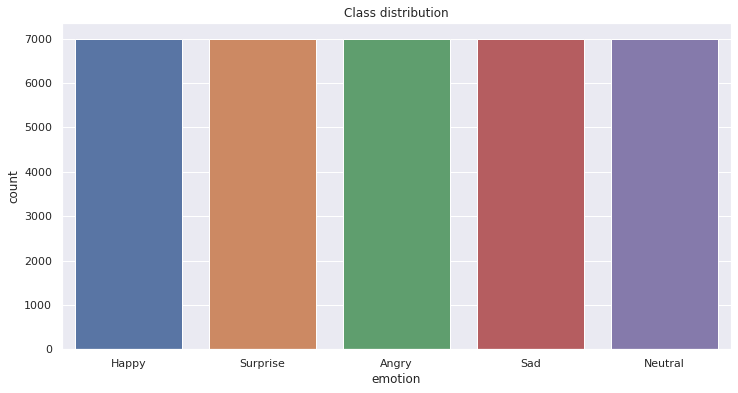

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
def class_imbalance_plot():
    print(df['emotion'].unique())
    plt.figure(figsize = (12,6))
    sns.set_theme(style='darkgrid')
    sns.countplot(x = 'emotion', data = df)
    plt.title('Class distribution')
    plt.savefig(imgs_path + 'class_distribution.png')
    plt.show()
    return

class_imbalance_plot()

# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [4]:
import librosa

# length of the longest utterance

def longest_utterance_length(df):
    longest_utterance = 0
    for file in df['path']:
        wavf, sample_rate = librosa.load(file, res_type='kaiser_fast', sr=44100)
        curr_length = librosa.get_duration(y=wavf, sr=sample_rate)
        if curr_length > longest_utterance:
            longest_utterance = curr_length
            
    return longest_utterance

_duration = longest_utterance_length(df)

In [5]:
print(_duration)

8.08


In [46]:
# log-mel spectrogram into mfcc

logMelSpecVal = []

def parse_audio_file(path_to_file, _sr, _duration):
    # load file
    wavf, sample_rate = librosa.load(path_to_file, res_type="kaiser_fast", duration=_duration, sr=_sr)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 44100, _duration)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,database,emotion,0,1,2,3,4,5,6,7,...,766,767,768,769,770,771,772,773,774,775
0,emodb,anger,-36.090981,-32.796627,-31.116634,-29.469265,-29.919529,-33.353619,-34.865524,-19.824419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,emodb,sadness,-26.864872,-24.903822,-24.706491,-25.334080,-26.270023,-25.506786,-24.641876,-24.913900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,emodb,anxiety,-26.956562,-27.515024,-26.380819,-25.832865,-27.194027,-26.763607,-28.808035,-27.407793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,emodb,sadness,-24.535583,-23.440098,-20.839142,-20.759388,-21.358418,-21.638031,-23.573610,-22.106657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,emodb,disgust,-34.375870,-29.413809,-28.761814,-29.789680,-28.418623,-29.296476,-30.873238,-28.353069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Predictions

# Results